# 目的
- チーム1の人とチーム2の人を入れ替えたデータでaugmentationを行う。
- testもやる

In [2]:
EXP_NAME = "e007_augment_w_test_group"

In [3]:
import polars as pl
import pandas as pd
import numpy as np

# from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import lightgbm as lgb

import seaborn as sns

In [4]:
pl.__version__

'1.17.1'

In [5]:
lgb.__version__

'4.5.0'

In [6]:
train = pd.read_csv("../data/train.csv") 
test = pd.read_csv("../data/test.csv")
monster = pd.read_csv("../data/monster.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")

In [7]:
train.head(2)

,Team1,Team2,Team1_win_ratio,battle1_winner,battle1_log,battle2_winner,battle2_log,battle3_winner,battle3_log,battle4_winner,...,battle6_winner,battle6_log,battle7_winner,battle7_log,battle8_winner,battle8_log,battle9_winner,battle9_log,battle10_winner,battle10_log
0,shu421 & YuYagi,kami & Kohecchi,0.7,kami & Kohecchi,バトル1開始！\nチーム1: shu421 & YuYagi VS チーム2: kami &...,shu421 & YuYagi,バトル2開始！\nチーム1: shu421 & YuYagi VS チーム2: kami &...,shu421 & YuYagi,バトル3開始！\nチーム1: shu421 & YuYagi VS チーム2: kami &...,shu421 & YuYagi,...,shu421 & YuYagi,バトル6開始！\nチーム1: shu421 & YuYagi VS チーム2: kami &...,kami & Kohecchi,バトル7開始！\nチーム1: shu421 & YuYagi VS チーム2: kami &...,shu421 & YuYagi,バトル8開始！\nチーム1: shu421 & YuYagi VS チーム2: kami &...,shu421 & YuYagi,バトル9開始！\nチーム1: shu421 & YuYagi VS チーム2: kami &...,shu421 & YuYagi,バトル10開始！\nチーム1: shu421 & YuYagi VS チーム2: kami ...
1,shu421 & YuYagi,kami & yuki,0.7,kami & yuki,バトル1開始！\nチーム1: shu421 & YuYagi VS チーム2: kami &...,kami & yuki,バトル2開始！\nチーム1: shu421 & YuYagi VS チーム2: kami &...,shu421 & YuYagi,バトル3開始！\nチーム1: shu421 & YuYagi VS チーム2: kami &...,shu421 & YuYagi,...,shu421 & YuYagi,バトル6開始！\nチーム1: shu421 & YuYagi VS チーム2: kami &...,shu421 & YuYagi,バトル7開始！\nチーム1: shu421 & YuYagi VS チーム2: kami &...,shu421 & YuYagi,バトル8開始！\nチーム1: shu421 & YuYagi VS チーム2: kami &...,shu421 & YuYagi,バトル9開始！\nチーム1: shu421 & YuYagi VS チーム2: kami &...,shu421 & YuYagi,バトル10開始！\nチーム1: shu421 & YuYagi VS チーム2: kami ...


In [8]:
test.tail(2)

,Team1,Team2
6166,Kinosuke & tattaka,K.T. & NSK
6167,Kinosuke & NSK,K.T. & tattaka


In [9]:
# augment
# groupで処理できるように、idをつける
train["group_id"] = train["Team1"] + "_" + train["Team2"]

train_aug = train.copy()
train_aug["Team1"] = train["Team2"]
train_aug["Team2"] = train["Team1"]
train_aug["Team1_win_ratio"] = 1 - train_aug["Team1_win_ratio"]

In [10]:
train = pd.concat([train, train_aug], axis=0).reset_index(drop=True)

In [11]:
# augment test
# 0,1,2という数字列を追加する
test["id"] = test.index

test_aug = test.copy()
test_aug["Team1"] = test["Team2"]
test_aug["Team2"] = test["Team1"]

test = pd.concat([test, test_aug], axis=0).reset_index(drop=True)

In [12]:
test.tail(2)

,Team1,Team2,id
12334,K.T. & NSK,Kinosuke & tattaka,6166
12335,K.T. & tattaka,Kinosuke & NSK,6167


# 特徴量生成

In [13]:
train["Team1_1_member"] = train["Team1"].str.split(" & ").apply(lambda x: x[0])
train["Team1_2_member"] = train["Team1"].str.split(" & ").apply(lambda x: x[1])

train["Team2_1_member"] = train["Team2"].str.split(" & ").apply(lambda x: x[0])
train["Team2_2_member"] = train["Team2"].str.split(" & ").apply(lambda x: x[1])

test["Team1_1_member"] = test["Team1"].str.split(" & ").apply(lambda x: x[0])
test["Team1_2_member"] = test["Team1"].str.split(" & ").apply(lambda x: x[1])

test["Team2_1_member"] = test["Team2"].str.split(" & ").apply(lambda x: x[0])
test["Team2_2_member"] = test["Team2"].str.split(" & ").apply(lambda x: x[1])

In [14]:
train = (
    train.merge(
        monster.add_suffix("_1_1"),
        how="left",
        left_on="Team1_1_member",
        right_on="monster_name_1_1"
    ).merge(
        monster.add_suffix("_1_2"),
        how="left",
        left_on="Team1_2_member",
        right_on="monster_name_1_2"
    ).merge(
        monster.add_suffix("_2_1"),
        how="left",
        left_on="Team2_1_member",
        right_on="monster_name_2_1"
    ).merge(
        monster.add_suffix("_2_2"),
        how="left",
        left_on="Team2_2_member",
        right_on="monster_name_2_2"
    )
)

In [15]:
test = (
    test.merge(
        monster.add_suffix("_1_1"),
        how="left",
        left_on="Team1_1_member",
        right_on="monster_name_1_1"
    ).merge(
        monster.add_suffix("_1_2"),
        how="left",
        left_on="Team1_2_member",
        right_on="monster_name_1_2"
    ).merge(
        monster.add_suffix("_2_1"),
        how="left",
        left_on="Team2_1_member",
        right_on="monster_name_2_1"
    ).merge(
        monster.add_suffix("_2_2"),
        how="left",
        left_on="Team2_2_member",
        right_on="monster_name_2_2"
    )
)

In [16]:
train.columns

Index(['Team1', 'Team2', 'Team1_win_ratio', 'battle1_winner', 'battle1_log',
       'battle2_winner', 'battle2_log', 'battle3_winner', 'battle3_log',
       'battle4_winner',
       ...
       'skill2_hitrate_2_2', 'skill2_attribute_2_2', 'skill2_attack_type_2_2',
       'skill2_status_effect_chance_2_2', 'skill3_name_2_2',
       'skill3_power_2_2', 'skill3_hitrate_2_2', 'skill3_attribute_2_2',
       'skill3_attack_type_2_2', 'skill3_status_effect_chance_2_2'],
      dtype='object', length=128)

In [17]:
# def sorted_team_1_member(row):
#     value = "__".join(sorted([row["Team1_1_member"], row["Team1_2_member"]]))
#     return value

# def sorted_team_2_member(row):
#     value = "__".join(sorted([row["Team2_1_member"], row["Team2_2_member"]]))
#     return value

# train["sorted_team_1_member"] = train.apply(lambda x :sorted_team_1_member(x), axis=1)
# train["sorted_team_2_member"] = train.apply(lambda x :sorted_team_2_member(x), axis=1)

# test["sorted_team_1_member"] = test.apply(lambda x :sorted_team_1_member(x), axis=1)
# test["sorted_team_2_member"] = test.apply(lambda x :sorted_team_2_member(x), axis=1)

In [18]:
train = pl.from_pandas(train)
test = pl.from_pandas(test)

In [21]:
USE_COL = ["Team1_1_member", "Team1_2_member", "Team2_1_member", "Team2_2_member"]
USE_COL += [col + "_1_1" for col in monster.columns.tolist() if col not in ("description", "monster_name")]
USE_COL += [col + "_1_2" for col in monster.columns.tolist() if col not in ("description", "monster_name")]
USE_COL += [col + "_2_1" for col in monster.columns.tolist() if col not in ("description", "monster_name")]
USE_COL += [col + "_2_2" for col in monster.columns.tolist() if col not in ("description", "monster_name")]
# USE_COL += ["sorted_team_1_member", "sorted_team_2_member"]

CATEGORICAL_FEATURE = [
    "Team1_1_member",
    "Team1_2_member",
    "Team2_1_member",
    "Team2_2_member",
    "monster_type_1_1",
    "monster_type_1_2",
    "monster_type_2_1",
    "monster_type_2_2",
    "skill1_attribute_1_1",
    "skill1_attribute_1_2",
    "skill1_attribute_2_1",
    "skill1_attribute_2_2",
    "skill2_attribute_1_1",
    "skill2_attribute_1_2",
    "skill2_attribute_2_1",
    "skill2_attribute_2_2",
    "skill3_attribute_1_1",
    "skill3_attribute_1_2",
    "skill3_attribute_2_1",
    "skill3_attribute_2_2",
    "skill1_name_1_1",
    "skill1_name_1_2",
    "skill1_name_2_1",
    "skill1_name_2_2",
    "skill1_attack_type_1_1",
    "skill1_attack_type_1_2",
    "skill1_attack_type_2_1",
    "skill1_attack_type_2_2",
    "skill2_name_1_1",
    "skill2_name_1_2",
    "skill2_name_2_1",
    "skill2_name_2_2",
    "skill2_attack_type_1_1",
    "skill2_attack_type_1_2",
    "skill2_attack_type_2_1",
    "skill2_attack_type_2_2",
    "skill3_name_1_1",
    "skill3_name_1_2",
    "skill3_name_2_1",
    "skill3_name_2_2",
    "skill3_attack_type_1_1",
    "skill3_attack_type_1_2",
    "skill3_attack_type_2_1",
    "skill3_attack_type_2_2",
    # "sorted_team_1_member",
    # "sorted_team_2_member"
]
TARGET_COL = "Team1_win_ratio"
FOLD_NUM = 5
SEED = 42

In [22]:
train[USE_COL].columns

['Team1_1_member',
 'Team1_2_member',
 'Team2_1_member',
 'Team2_2_member',
 'monster_type_1_1',
 'attack_1_1',
 'defense_1_1',
 'speed_1_1',
 'hp_1_1',
 'skill1_name_1_1',
 'skill1_power_1_1',
 'skill1_hitrate_1_1',
 'skill1_attribute_1_1',
 'skill1_attack_type_1_1',
 'skill1_status_effect_chance_1_1',
 'skill2_name_1_1',
 'skill2_power_1_1',
 'skill2_hitrate_1_1',
 'skill2_attribute_1_1',
 'skill2_attack_type_1_1',
 'skill2_status_effect_chance_1_1',
 'skill3_name_1_1',
 'skill3_power_1_1',
 'skill3_hitrate_1_1',
 'skill3_attribute_1_1',
 'skill3_attack_type_1_1',
 'skill3_status_effect_chance_1_1',
 'monster_type_1_2',
 'attack_1_2',
 'defense_1_2',
 'speed_1_2',
 'hp_1_2',
 'skill1_name_1_2',
 'skill1_power_1_2',
 'skill1_hitrate_1_2',
 'skill1_attribute_1_2',
 'skill1_attack_type_1_2',
 'skill1_status_effect_chance_1_2',
 'skill2_name_1_2',
 'skill2_power_1_2',
 'skill2_hitrate_1_2',
 'skill2_attribute_1_2',
 'skill2_attack_type_1_2',
 'skill2_status_effect_chance_1_2',
 'skill3_n

In [20]:
# Categorical型への変換
train = train.with_columns(pl.col(CATEGORICAL_FEATURE).cast(pl.Categorical))
test = test.with_columns(pl.col(CATEGORICAL_FEATURE).cast(pl.Categorical))

In [22]:
train["group_id"]

group_id
str
"""shu421 & YuYagi_kami & Kohecch…"
"""shu421 & YuYagi_kami & yuki"""
"""shu421 & YuYagi_kami & suguuuu…"
"""shu421 & YuYagi_kami & ktm"""
"""shu421 & YuYagi_kami & sinchir…"
…
"""goosehaaan & NSK_chumajin & K.…"
"""goosehaaan & NSK_Kinosuke & K.…"
"""chumajin & Kinosuke_K.T. & NSK"""


In [27]:
# Foldの作成
fold_arr = np.zeros(train.height)
fold = GroupKFold(n_splits=FOLD_NUM)
# fold = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)

for idx, (_, val_idx) in enumerate(fold.split(train, train[TARGET_COL], train["group_id"].to_list())):
    fold_arr[val_idx] = idx

train = train.with_columns(pl.Series(fold_arr).cast(pl.Int64).alias("fold"))

In [41]:
train.filter(
    pl.col("fold") == 0
)["group_id"].value_counts()

group_id,count
str,u32
"""YuYagi & goosehaaan_currypurin…",2
"""suguuuuu & sinchir0_ktm & K.T.""",2
"""sinchir0 & Daikon99_sue124 & c…",2
"""ktm & sue124_Daikon99 & K.T.""",2
"""kami & sinchir0_sue124 & chuma…",2
…,…
"""shu421 & sue124_YuYagi & ktm""",2
"""suguuuuu & Daikon99_currypurin…",2
"""currypurin & K.T._goosehaaan &…",2


In [42]:
# LightGBMで用いるパラメータを指定
params = {
    "objective": "regression",
    "metric": "rmse",
    "max_depth": -1,
    "min_data_in_leaf": 10,  # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.01,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、-1はFatalなログのみを出力
    "seed": SEED,  # ランダムシードの固定
    "lambda_l1": 0.4,  # 正則化のためのパラメータ
    "lambda_l2": 0.4,  # 正則化のためのパラメータ
}

In [43]:
# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train.filter(pl.col("fold") != fold)
    valid_fold = train.filter(pl.col("fold") == fold)

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.select(USE_COL)
    X_valid = valid_fold.select(USE_COL)
    y_train = train_fold.select(TARGET_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train.to_pandas(), y_train.to_pandas())
    lgb_eval = lgb.Dataset(
        X_valid.to_pandas(), y_valid.to_pandas(), reference=lgb_train
    )

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(
                stopping_rounds=100
            ),  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
            lgb.log_evaluation(100),  # 指定したiteration回数ごとにlogを出力する
        ],
    )

    # モデルを保存
    models.append([fold, model])

Start fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.209728	valid_1's rmse: 0.210518
[200]	training's rmse: 0.174442	valid_1's rmse: 0.177819
[300]	training's rmse: 0.157355	valid_1's rmse: 0.163063
[400]	training's rmse: 0.146545	valid_1's rmse: 0.154366
[500]	training's rmse: 0.140146	valid_1's rmse: 0.149256
[600]	training's rmse: 0.135827	valid_1's rmse: 0.146336
[700]	training's rmse: 0.13278	valid_1's rmse: 0.144597
[800]	training's rmse: 0.1305	valid_1's rmse: 0.143742
[900]	training's rmse: 0.128534	valid_1's rmse: 0.143161
[1000]	training's rmse: 0.126979	valid_1's rmse: 0.142902
[1100]	training's rmse: 0.125481	valid_1's rmse: 0.142579
[1200]	training's rmse: 0.124191	valid_1's rmse: 0.142441
[1300]	training's rmse: 0.123	valid_1's rmse: 0.142378
[1400]	training's rmse: 0.121899	valid_1's rmse: 0.142269
[1500]	training's rmse: 0.12086	valid_1's rmse: 0.142357
Early stopping, best iteration is:
[1410]	training's rmse: 0.121796	val

In [44]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# foldの値と学習済みモデルを利用し、モデルの評価を行う
for fold, model in models:
    valid_fold = train.filter(pl.col("fold") == fold)

    X_valid = valid_fold.select(USE_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # validデータに対する推論
    y_valid_pred = model.predict(
        X_valid.to_pandas(), num_iteration=model.best_iteration
    )

    score = root_mean_squared_error(y_valid, y_valid_pred)
    print(f"fold {fold} Score: {score}")

    is_valid = train.get_column("fold") == fold
    oof[is_valid] = y_valid_pred

fold 0 Score: 0.1422554769184321
fold 1 Score: 0.13585805337929602
fold 2 Score: 0.1417371081969033
fold 3 Score: 0.14942453817719908
fold 4 Score: 0.1428163660885796


In [45]:
oof_score = root_mean_squared_error(train.get_column(TARGET_COL), oof)
oof_score

0.14248343500459223

<Axes: >

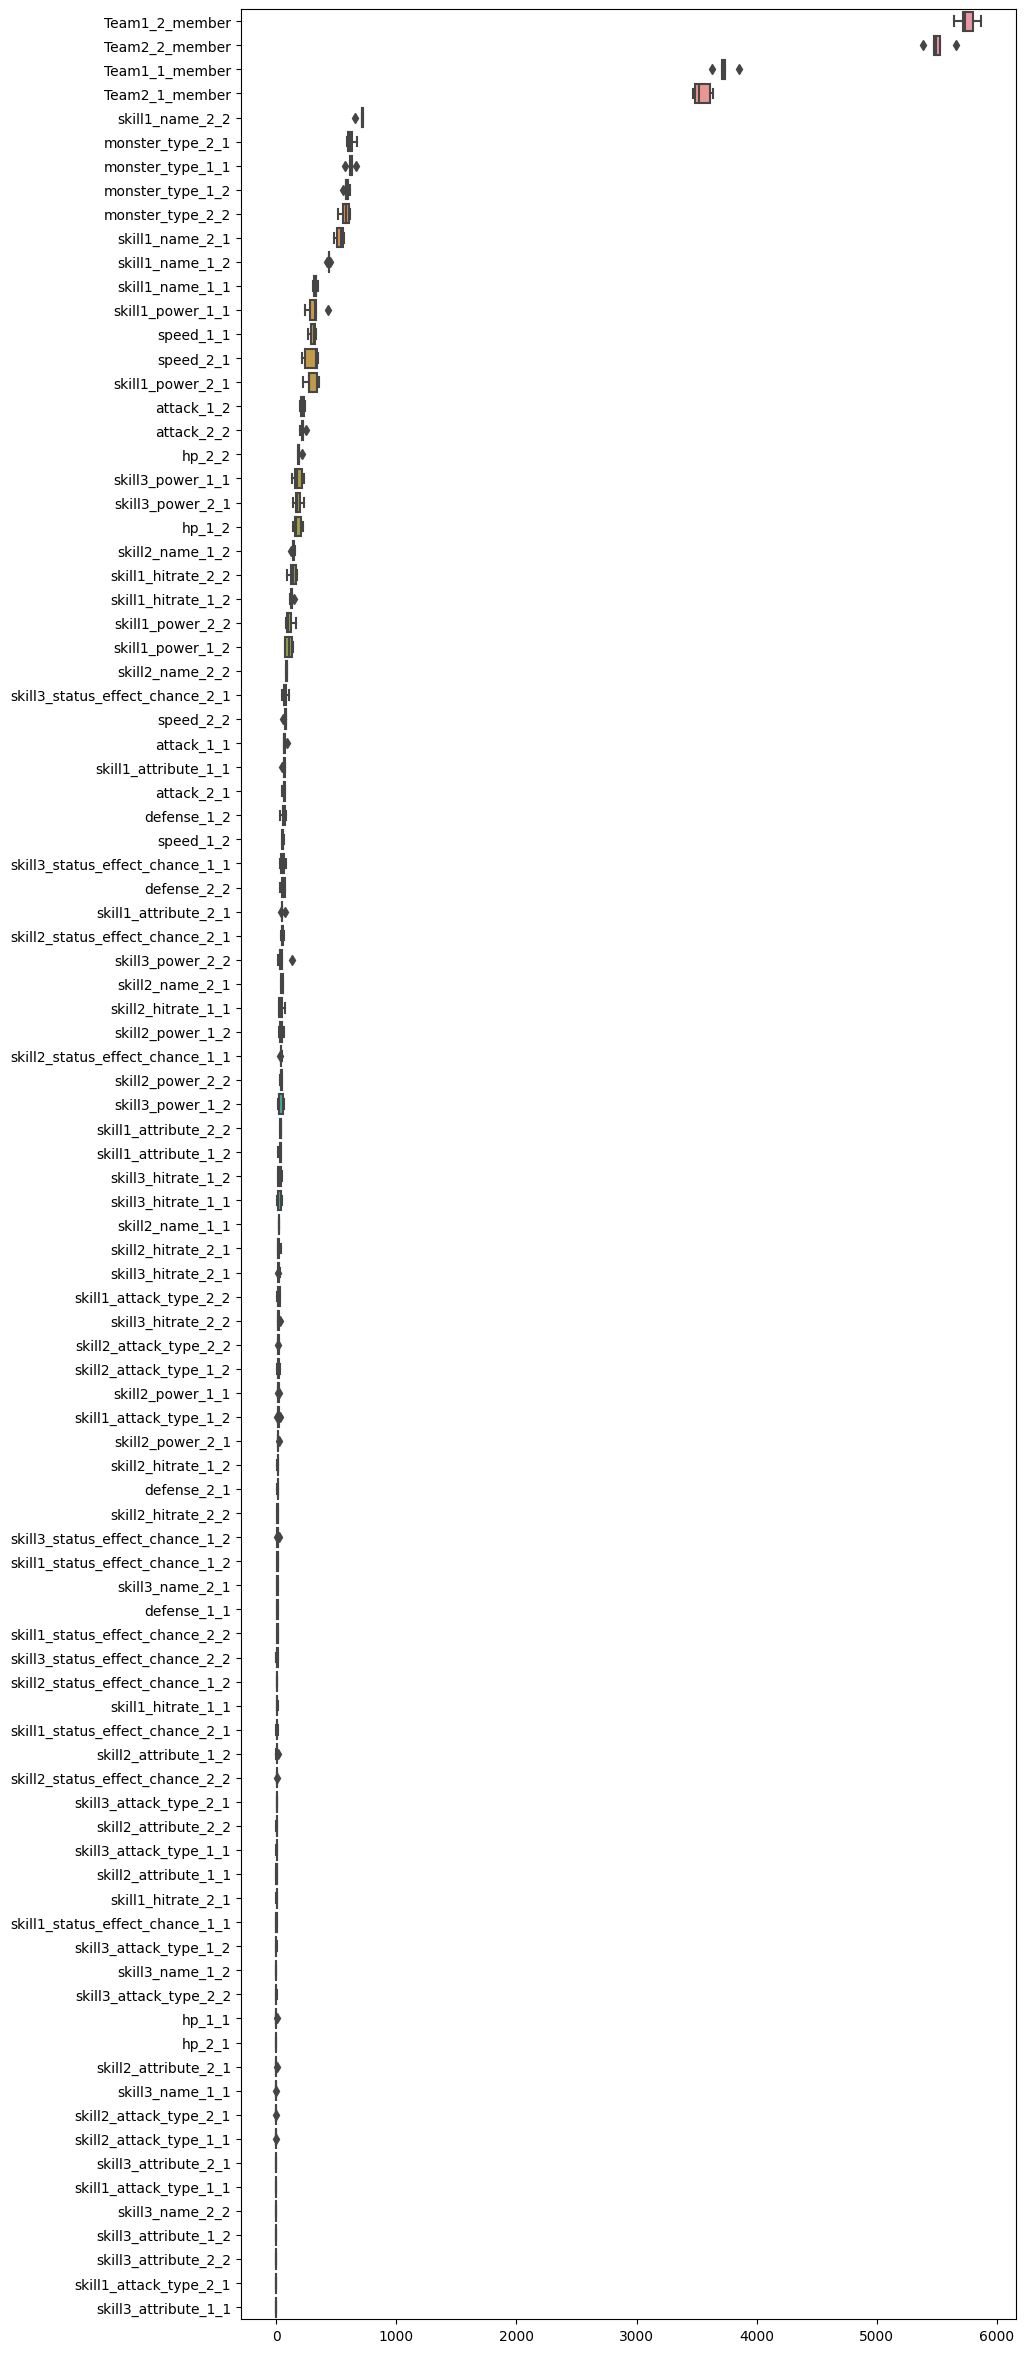

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = [
    model.feature_importance(importance_type="gain") for _, model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=USE_COL)

order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()
plt.figure(figsize=(10, 30))
sns.boxplot(data=feature_importances_df, orient="h", order=order)

In [47]:
pred = np.array([model.predict(test[USE_COL].to_pandas()) for _, model in models])
pred = np.mean(pred, axis=0)
pred

array([0.75432371, 0.73388277, 0.81990495, ..., 0.71931356, 0.78605148,
       0.27093713])

In [48]:
len(pred)

12336

In [49]:
# 追加したデータについては、1-を行う。
test = test.to_pandas()
test["pred"] = pred

In [50]:
test["pred"]

0        0.754324
1        0.733883
2        0.819905
3        0.559888
4        0.520134
           ...   
12331    0.180769
12332    0.226265
12333    0.719314
12334    0.786051
12335    0.270937
Name: pred, Length: 12336, dtype: float64

In [51]:
test.loc[len(pd.read_csv("../data/test.csv")):, "pred"]

6168     0.243120
6169     0.255942
6170     0.175885
6171     0.423757
6172     0.457300
           ...   
12331    0.180769
12332    0.226265
12333    0.719314
12334    0.786051
12335    0.270937
Name: pred, Length: 6168, dtype: float64

In [52]:
test.loc[len(pd.read_csv("../data/test.csv")):, "pred"] = 1 - test.loc[len(pd.read_csv("../data/test.csv")):, "pred"]

In [53]:
test["pred"]

0        0.754324
1        0.733883
2        0.819905
3        0.559888
4        0.520134
           ...   
12331    0.819231
12332    0.773735
12333    0.280686
12334    0.213949
12335    0.729063
Name: pred, Length: 12336, dtype: float64

In [54]:
test.loc[len(pd.read_csv("../data/test.csv")):, "pred"]

6168     0.756880
6169     0.744058
6170     0.824115
6171     0.576243
6172     0.542700
           ...   
12331    0.819231
12332    0.773735
12333    0.280686
12334    0.213949
12335    0.729063
Name: pred, Length: 6168, dtype: float64

In [55]:
pred_new = test.groupby("id")["pred"].mean().values.tolist()

In [56]:
# sample_submission["Team1_win_ratio"] = pred
sample_submission["Team1_win_ratio"] = pred_new
sample_submission.to_csv(f"../submission/{EXP_NAME}_CV{oof_score:.4f}.csv", index=False)

In [57]:
sample_submission

,Team1_win_ratio,Team1_Team2
0,0.755602,shu421 & YuYagi_kami & T88
1,0.738970,shu421 & YuYagi_kami & RYUSHI
2,0.822010,shu421 & YuYagi_kami & tattaka
3,0.568066,shu421 & YuYagi_Kohecchi & T88
4,0.531417,shu421 & YuYagi_Kohecchi & RYUSHI
...,...,...
6163,0.795129,chumajin & NSK_Kinosuke & tattaka
6164,0.760775,chumajin & NSK_K.T. & tattaka
6165,0.268583,Kinosuke & K.T._tattaka & NSK
6166,0.197945,Kinosuke & tattaka_K.T. & NSK
